Exercício 2 - Faça 3 modelos de regressão linear múltipla para predizer da melhor forma possível o preço dos automóveis.

preco_carro.csv

 

1º Modelo com todas variáveis

2º Modelo com as 3 variáveis mais correlacionadas

3º Modelo com as 5 variáveis mais correlacionadas

   

Na análise de dados e do modelo devem contemplar:

1 – Análise descritiva

2 – Calculo de correlação e covariância

3 – Faça o modelo de regressão

4 – Realize a análise de resíduos

5 – Análise de multicolinearidade

6 – Análise de outlier

7 – Comparação de modelos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats


In [2]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (12, 6)

df = pd.read_csv('../../data/preco_carro.csv')
display(df.head())

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


## 1. Análise Descritiva


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   v.id           1000 non-null   int64  
 1   on road old    1000 non-null   int64  
 2   on road now    1000 non-null   int64  
 3   years          1000 non-null   int64  
 4   km             1000 non-null   int64  
 5   rating         1000 non-null   int64  
 6   condition      1000 non-null   int64  
 7   economy        1000 non-null   int64  
 8   top speed      1000 non-null   int64  
 9   hp             1000 non-null   int64  
 10  torque         1000 non-null   int64  
 11  current price  1000 non-null   float64
dtypes: float64(1), int64(11)
memory usage: 93.9 KB


None

In [4]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
v.id,1000.0,500.5000,288.819436,1.0,250.75,500.50,750.250,1000.0
on road old,1000.0,601648.2860,58407.246204,500265.0,548860.50,601568.00,652267.250,699859.0
on road now,1000.0,799131.3970,57028.950200,700018.0,750997.75,798168.00,847563.250,899797.0
years,1000.0,4.5610,1.719079,2.0,3.00,5.00,6.000,7.0
km,1000.0,100274.4300,29150.463233,50324.0,74367.50,100139.50,125048.000,149902.0
rating,1000.0,2.9880,1.402791,1.0,2.00,3.00,4.000,5.0
condition,1000.0,5.5920,2.824449,1.0,3.00,6.00,8.000,10.0
economy,1000.0,11.6250,2.230549,8.0,10.00,12.00,13.000,15.0
top speed,1000.0,166.8930,19.288380,135.0,150.00,166.00,184.000,200.0
hp,1000.0,84.5460,20.516940,50.0,67.00,84.00,102.000,120.0


In [5]:
# Verificar valores faltantes
print("Valores faltantes por coluna:")
print(df.isnull().sum())
print(f"\nTotal de linhas: {len(df)}")


Valores faltantes por coluna:
v.id             0
on road old      0
on road now      0
years            0
km               0
rating           0
condition        0
economy          0
top speed        0
hp               0
torque           0
current price    0
dtype: int64

Total de linhas: 1000


In [6]:
# Preparar variáveis: remover v.id (ID) e definir variável alvo
# Vamos usar todas as variáveis numéricas exceto v.id e current price como preditoras
variaveis_preditoras = [col for col in df.columns if col not in ['v.id', 'current price']]
print("Variáveis preditoras:", variaveis_preditoras)
print(f"\nVariável alvo: current price")


Variáveis preditoras: ['on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque']

Variável alvo: current price


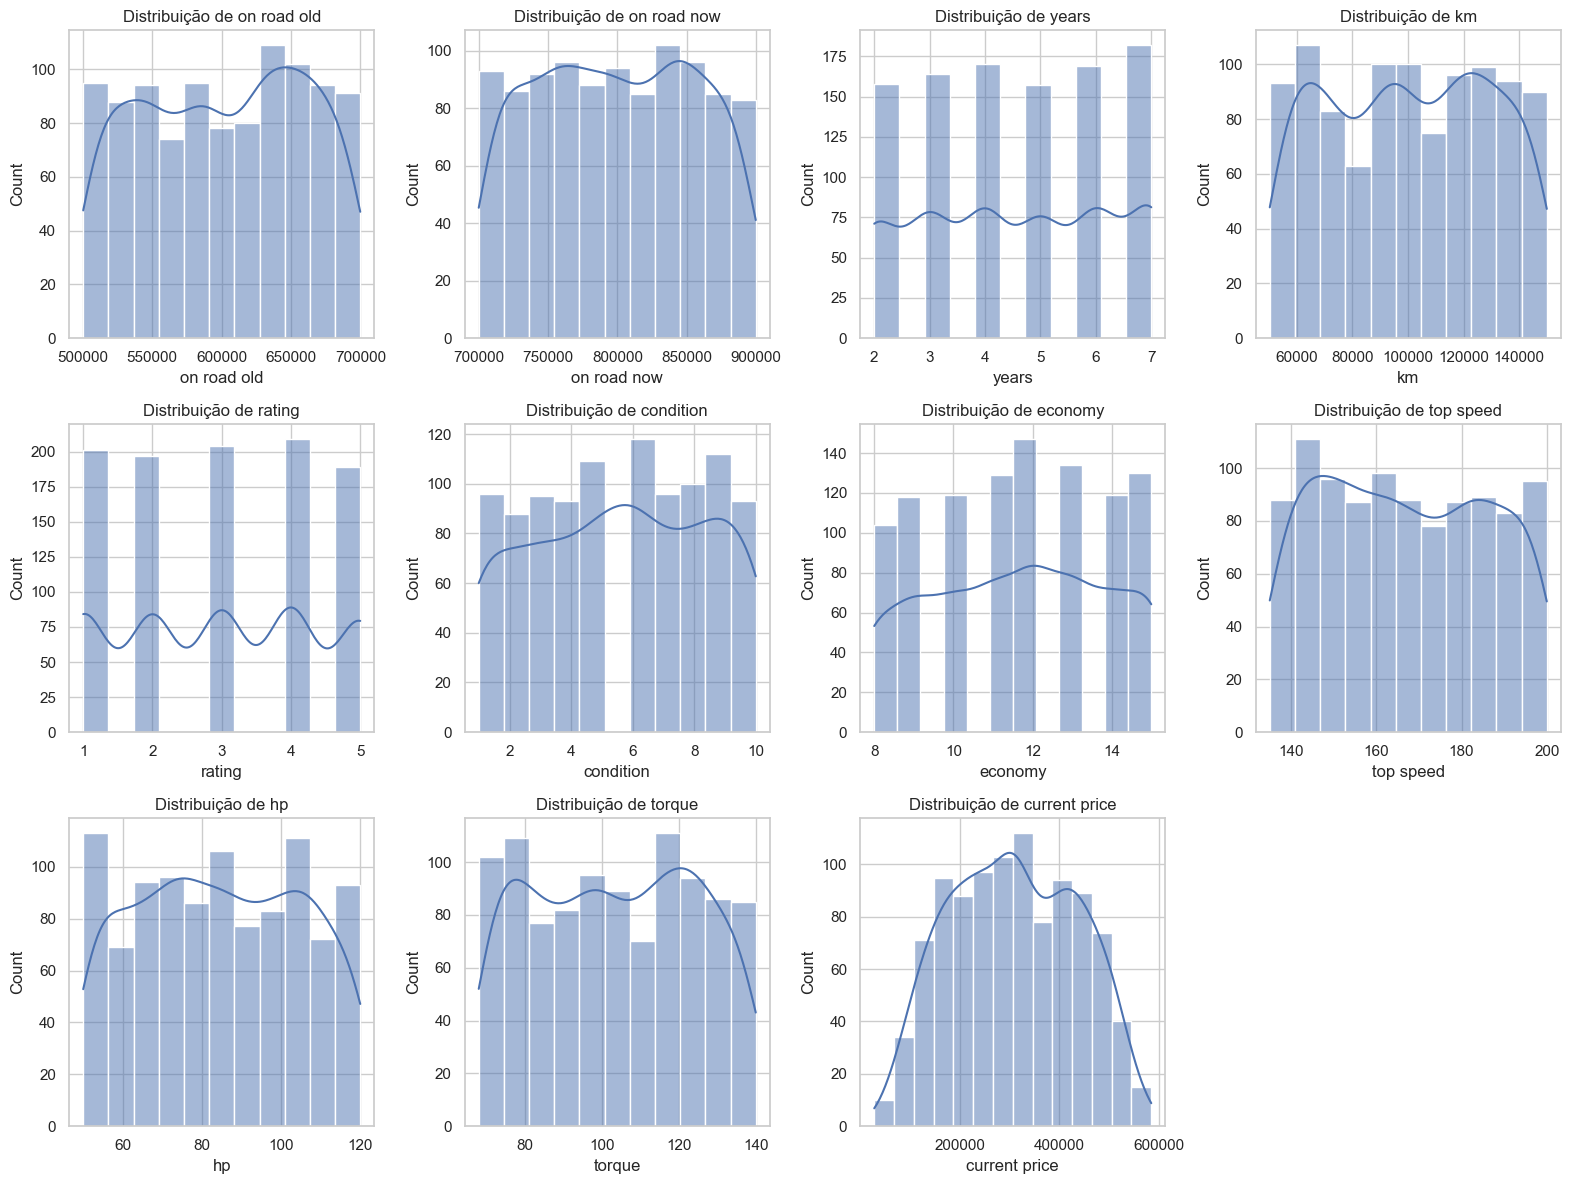

In [7]:
# Visualizações das distribuições
n_vars = len(variaveis_preditoras) + 1  # +1 para a variável alvo
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(variaveis_preditoras + ['current price']):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição de {col}")

# Ocultar eixos extras
for i in range(n_vars, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


## 2. Cálculo de Correlação e Covariância


In [8]:
# Calcular correlação e covariância
corr_matrix = df[variaveis_preditoras + ['current price']].corr()
cov_matrix = df[variaveis_preditoras + ['current price']].cov()

print("Matriz de Correlação:")
corr_matrix


Matriz de Correlação:


,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
on road old,1.000000,0.034113,0.007207,0.007488,-0.050717,-0.015682,-0.030097,-0.023816,-0.049266,0.008950,0.233035
on road now,0.034113,1.000000,0.004609,-0.053202,0.028280,-0.005043,-0.015880,0.012699,-0.012719,0.017955,0.282793
years,0.007207,0.004609,1.000000,-0.002089,0.027285,0.053579,0.050220,0.025148,-0.003272,0.028859,-0.011854
km,0.007488,-0.053202,-0.002089,1.000000,-0.039930,-0.013640,0.032680,0.026450,-0.052918,0.013566,-0.935924
rating,-0.050717,0.028280,0.027285,-0.039930,1.000000,0.015943,-0.009757,-0.042222,-0.022623,0.004408,0.035038
condition,-0.015682,-0.005043,0.053579,-0.013640,0.015943,1.000000,0.058788,0.018472,-0.071552,0.047805,0.110108
economy,-0.030097,-0.015880,0.050220,0.032680,-0.009757,0.058788,1.000000,-0.059402,-0.016782,0.041632,-0.034711
top speed,-0.023816,0.012699,0.025148,0.026450,-0.042222,0.018472,-0.059402,1.000000,0.057827,-0.019697,-0.027993
hp,-0.049266,-0.012719,-0.003272,-0.052918,-0.022623,-0.071552,-0.016782,0.057827,1.000000,-0.013817,0.030238
torque,0.008950,0.017955,0.028859,0.013566,0.004408,0.047805,0.041632,-0.019697,-0.013817,1.000000,-0.002290


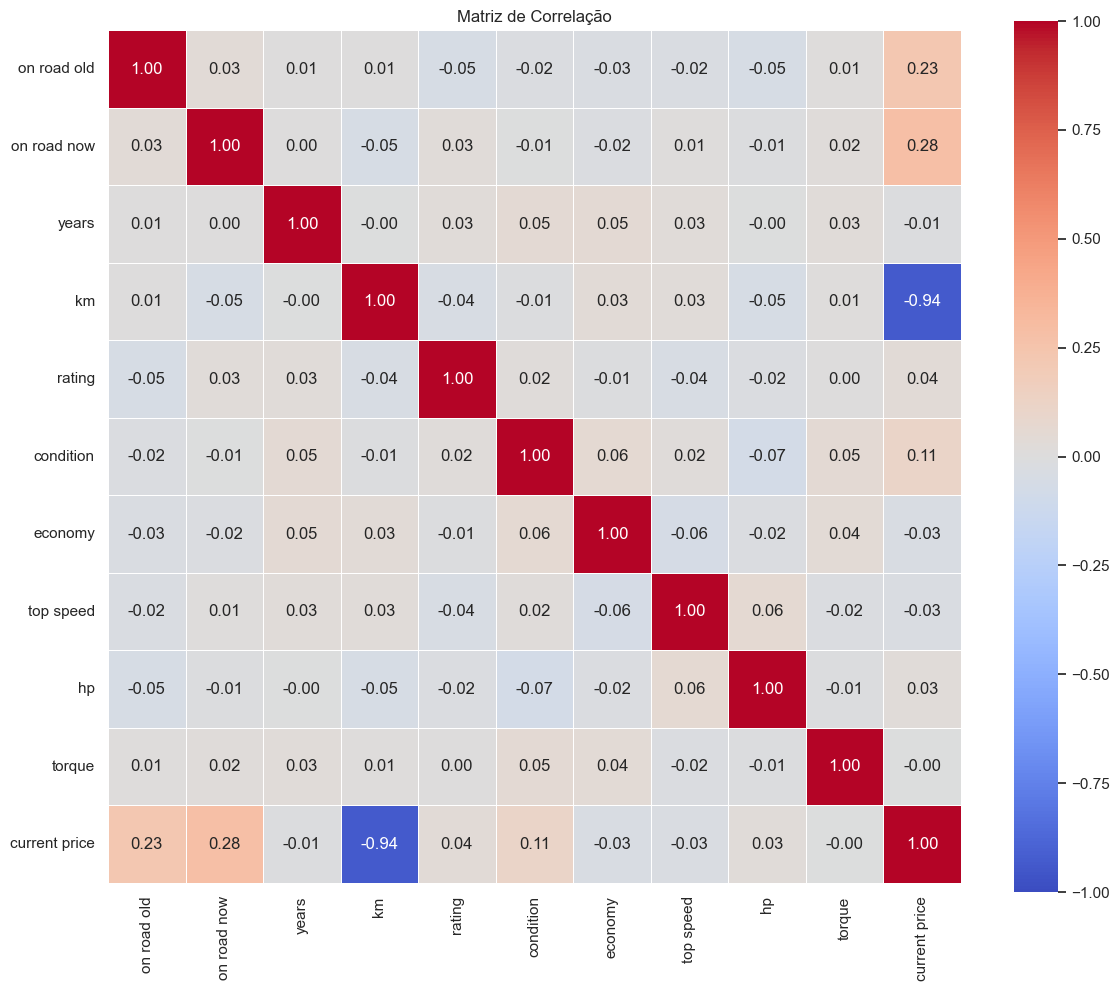

In [9]:
# Visualizar matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, 
            square=True, linewidths=0.5)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()


In [10]:
# Identificar variáveis mais correlacionadas com current price
correlacoes_com_preco = corr_matrix['current price'].drop('current price').abs().sort_values(ascending=False)
print("Correlações absolutas com 'current price' (ordenadas):")
print(correlacoes_com_preco)

# Selecionar as 3 e 5 mais correlacionadas
top_3 = correlacoes_com_preco.head(3).index.tolist()
top_5 = correlacoes_com_preco.head(5).index.tolist()

print(f"\nTop 3 variáveis mais correlacionadas: {top_3}")
print(f"Top 5 variáveis mais correlacionadas: {top_5}")


Correlações absolutas com 'current price' (ordenadas):
km             0.935924
on road now    0.282793
on road old    0.233035
condition      0.110108
rating         0.035038
economy        0.034711
hp             0.030238
top speed      0.027993
years          0.011854
torque         0.002290
Name: current price, dtype: float64

Top 3 variáveis mais correlacionadas: ['km', 'on road now', 'on road old']
Top 5 variáveis mais correlacionadas: ['km', 'on road now', 'on road old', 'condition', 'rating']


## 3. Modelos de Regressão Múltipla

### 3.1. Modelo 1: Todas as Variáveis


In [11]:
# Modelo 1: Todas as variáveis
X1 = df[variaveis_preditoras]
y = df['current price']

X1_const = sm.add_constant(X1)
modelo1 = sm.OLS(y, X1_const)
resultados1 = modelo1.fit()
resultados1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          current price   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.072e+04
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:01:11   Log-Likelihood:                -10488.
No. Observations:                1000   AIC:                         2.100e+04
Df Residuals:                     989   BIC:                         2.105e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.383e+04   6046.330     -2.287      0.022   -2.57e+04   -1961.431
on road old     0.5057      0.005    106.452      0.000       0.496       0.515
on road now     0.5003      0.005    102.949      0.000       0.491       0.510
years       -1622.3890    161.327    -10.057      0.000   -1938.972   -1305.806
km             -3.9961      0.010   -419.521      0.000      -4.015      -3.977
rating        230.9884    197.816      1.168      0.243    -157.199     619.175
condition    4628.4689     98.541     46.970      0.000    4435.096    4821.842
economy        62.4643    124.716      0.501      0.617    -182.275     307.203
top speed     -14.5732     14.413     -1.011      0.312     -42.856      13.710
hp             20.3599     13.569      1.500      0.134      -6.268      46.988
torque         -1.7328     13.157     -0.132      0.895     -27.551      24.086
==============================================================================
Omnibus:                       83.060   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.422
Skew:                           0.736   Prob(JB):                     1.15e-21
Kurtosis:                       2.620   Cond. No.                     2.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.2. Modelo 2: Top 3 Variáveis Mais Correlacionadas


In [12]:
# Modelo 2: Top 3 variáveis
X2 = df[top_3]
X2_const = sm.add_constant(X2)
modelo2 = sm.OLS(y, X2_const)
resultados2 = modelo2.fit()
resultados2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          current price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 2.079e+04
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:01:11   Log-Likelihood:                -11087.
No. Observations:                1000   AIC:                         2.218e+04
Df Residuals:                     996   BIC:                         2.220e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9725.7449   8829.831      1.101      0.271   -7601.461    2.71e+04
km             -4.0034      0.017   -232.651      0.000      -4.037      -3.970
on road now     0.4988      0.009     56.675      0.000       0.482       0.516
on road old     0.5014      0.009     58.426      0.000       0.485       0.518
==============================================================================
Omnibus:                      210.448   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.975
Skew:                           1.389   Prob(JB):                     8.28e-78
Kurtosis:                       3.898   Cond. No.                     1.78e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3. Modelo 3: Top 5 Variáveis Mais Correlacionadas


In [13]:
# Modelo 3: Top 5 variáveis
X3 = df[top_5]
X3_const = sm.add_constant(X3)
modelo3 = sm.OLS(y, X3_const)
resultados3 = modelo3.fit()
resultados3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          current price   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 3.763e+04
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:01:11   Log-Likelihood:                -10539.
No. Observations:                1000   AIC:                         2.109e+04
Df Residuals:                     994   BIC:                         2.112e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.001e+04   5197.473     -3.850      0.000   -3.02e+04   -9808.943
km             -3.9970      0.010   -401.036      0.000      -4.017      -3.977
on road now     0.4998      0.005     98.101      0.000       0.490       0.510
on road old     0.5050      0.005    101.541      0.000       0.495       0.515
condition    4565.4356    102.664     44.470      0.000    4363.972    4766.899
rating        177.5388    207.172      0.857      0.392    -229.006     584.083
==============================================================================
Omnibus:                       55.912   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.211
Skew:                           0.593   Prob(JB):                     3.10e-14
Kurtosis:                       2.707   Cond. No.                     1.81e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4. Análise de Resíduos


In [14]:
def analise_residuos(resultados, modelo_nome, X_data):
    """Função para análise completa de resíduos"""
    residuos = resultados.resid
    fitted = resultados.fittedvalues
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Resíduos vs Valores Ajustados
    axes[0, 0].scatter(fitted, residuos, alpha=0.6)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Valores Ajustados')
    axes[0, 0].set_ylabel('Resíduos')
    axes[0, 0].set_title(f'{modelo_nome}: Resíduos vs Ajustados')
    
    # Distribuição dos resíduos
    axes[0, 1].hist(residuos, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Resíduos')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].set_title(f'{modelo_nome}: Distribuição dos Resíduos')
    
    # Q-Q Plot
    sm.qqplot(residuos, line='45', ax=axes[1, 0])
    axes[1, 0].set_title(f'{modelo_nome}: Q-Q Plot')
    
    # Resíduos padronizados
    residuos_padronizados = residuos / np.std(residuos)
    axes[1, 1].scatter(fitted, residuos_padronizados, alpha=0.6)
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].axhline(2, color='orange', linestyle='--', label='±2σ')
    axes[1, 1].axhline(-2, color='orange', linestyle='--')
    axes[1, 1].set_xlabel('Valores Ajustados')
    axes[1, 1].set_ylabel('Resíduos Padronizados')
    axes[1, 1].set_title(f'{modelo_nome}: Resíduos Padronizados')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print(f"\n=== Estatísticas dos Resíduos - {modelo_nome} ===")
    print(f"Média dos resíduos: {residuos.mean():.6f}")
    print(f"Desvio padrão dos resíduos: {residuos.std():.4f}")
    print(f"Estatística de Durbin-Watson: {durbin_watson(residuos):.4f}")
    print()


### 4.1. Resíduos - Modelo 1 (Todas as Variáveis)


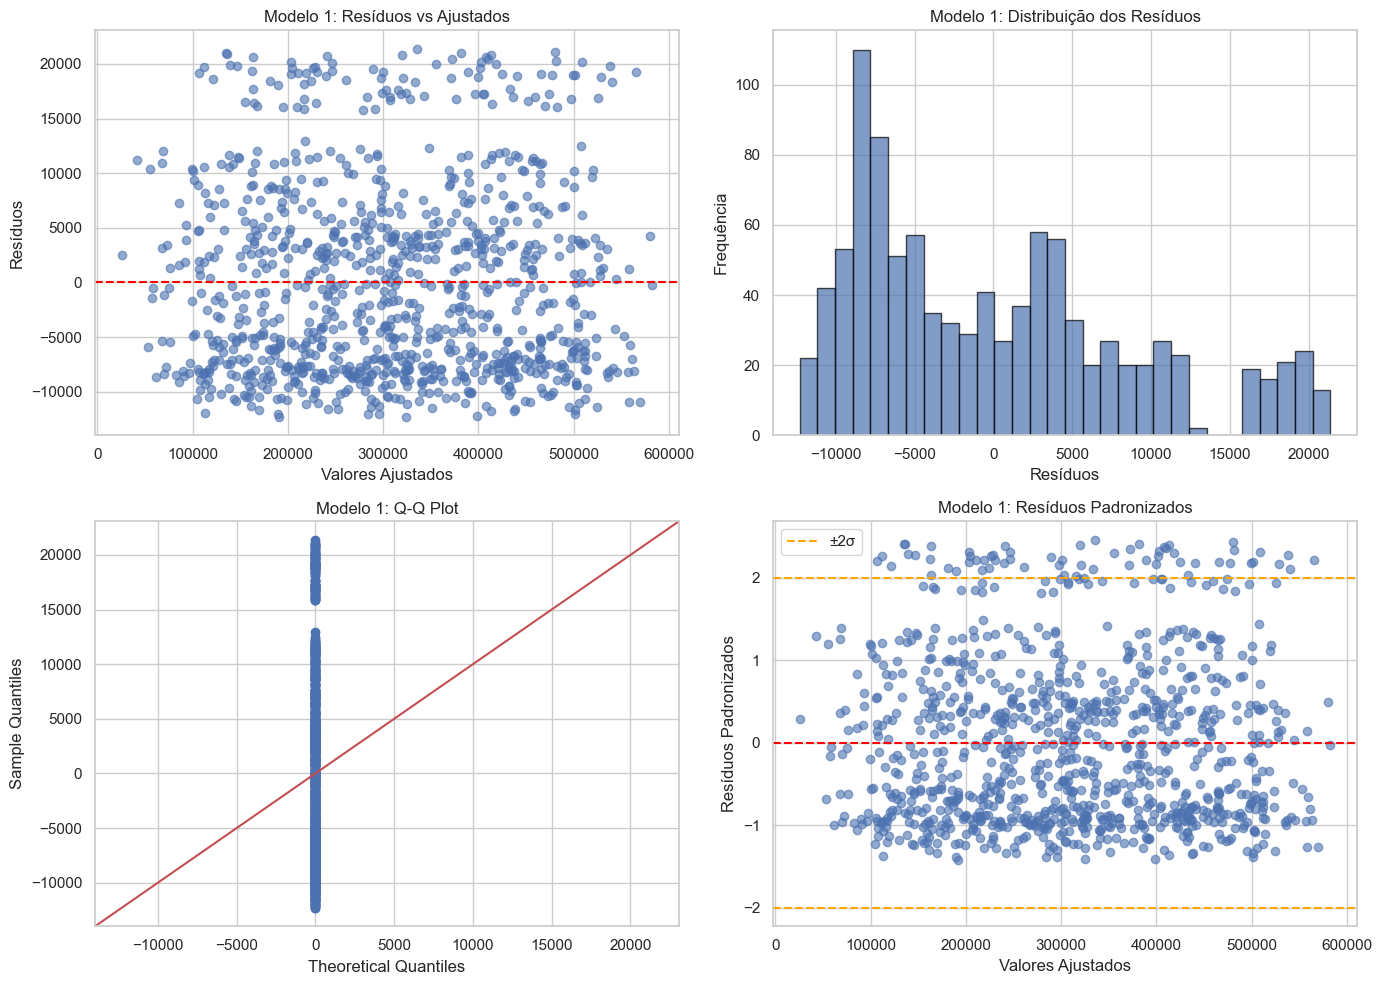


=== Estatísticas dos Resíduos - Modelo 1 ===
Média dos resíduos: -0.000000
Desvio padrão dos resíduos: 8689.4242
Estatística de Durbin-Watson: 2.0375



In [15]:
analise_residuos(resultados1, "Modelo 1", X1)


### 4.2. Resíduos - Modelo 2 (Top 3 Variáveis)


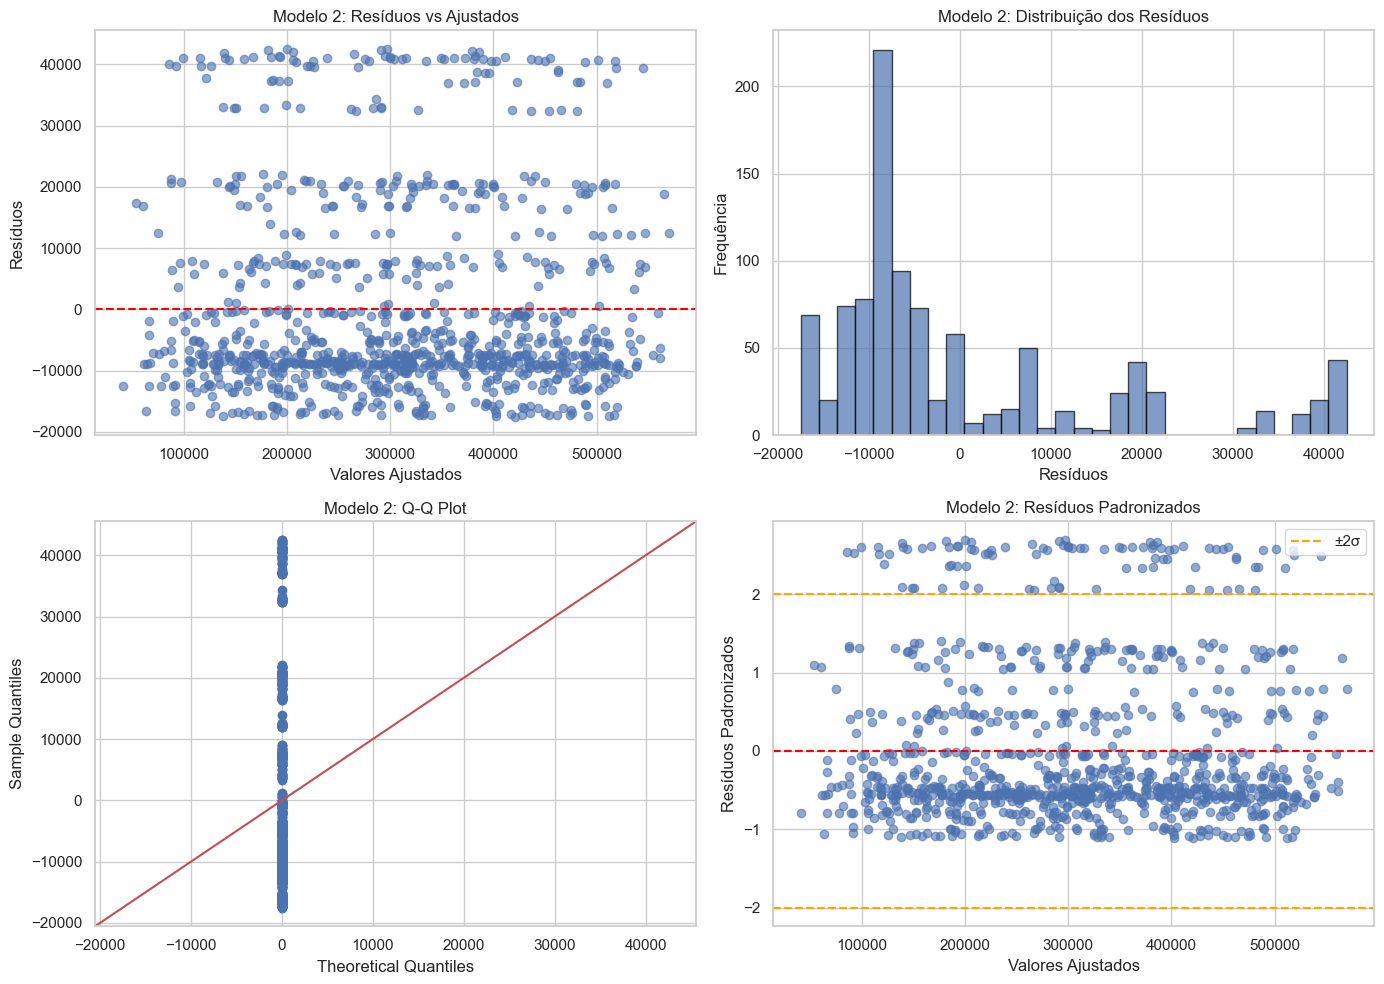


=== Estatísticas dos Resíduos - Modelo 2 ===
Média dos resíduos: 0.000000
Desvio padrão dos resíduos: 15807.5621
Estatística de Durbin-Watson: 1.9722



In [16]:
analise_residuos(resultados2, "Modelo 2", X2)


### 4.3. Resíduos - Modelo 3 (Top 5 Variáveis)


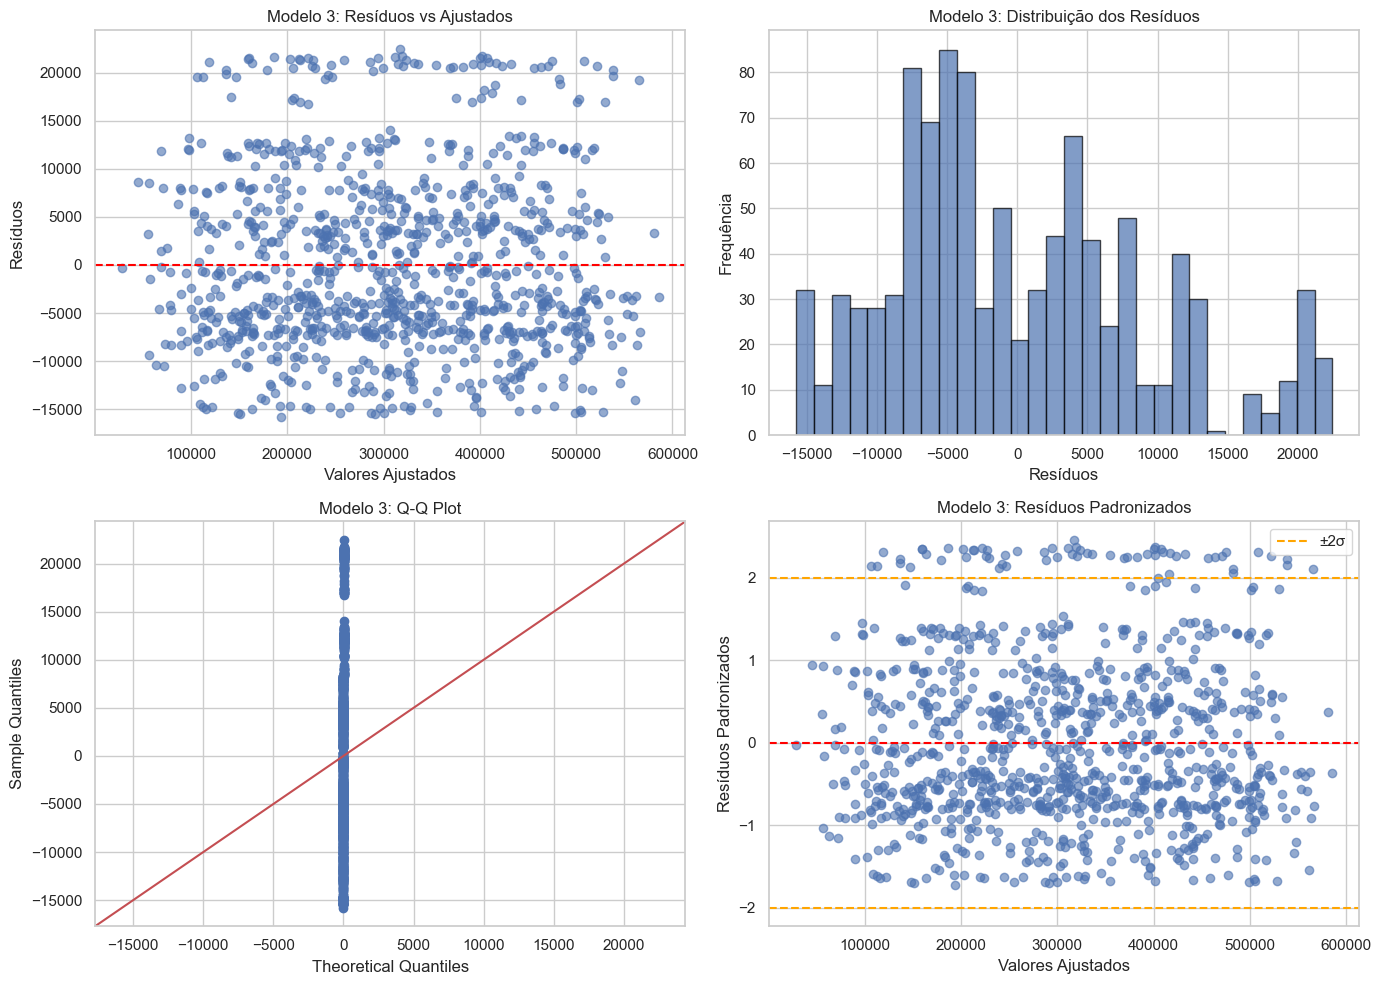


=== Estatísticas dos Resíduos - Modelo 3 ===
Média dos resíduos: 0.000000
Desvio padrão dos resíduos: 9139.0067
Estatística de Durbin-Watson: 2.0328



In [17]:
analise_residuos(resultados3, "Modelo 3", X3)


## 5. Análise de Multicolinearidade (VIF)


In [18]:
def calcular_vif(X_data, modelo_nome):
    """Calcula VIF para um conjunto de variáveis"""
    X_with_const = sm.add_constant(X_data)
    vif_data = pd.DataFrame({
        'Variável': X_with_const.columns,
        'VIF': [variance_inflation_factor(X_with_const.values, i) 
                for i in range(X_with_const.shape[1])]
    })
    vif_data = vif_data[vif_data['Variável'] != 'const']  # Remover constante
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print(f"\n=== VIF - {modelo_nome} ===")
    print(vif_data.to_string(index=False))
    print(f"\nInterpretação:")
    print(f"- VIF < 5: Multicolinearidade baixa")
    print(f"- 5 ≤ VIF < 10: Multicolinearidade moderada")
    print(f"- VIF ≥ 10: Multicolinearidade alta (problema)")
    print()
    
    return vif_data


In [ ]:
vif1 = calcular_vif(X1, "Modelo 1 (Todas as Variáveis)")


=== VIF - Modelo 1 (Todas as Variáveis) ===
   Variável      VIF
         hp 1.015192
  condition 1.014647
    economy 1.013642
  top speed 1.012291
         km 1.009872
     rating 1.008609
on road old 1.008517
      years 1.007445
on road now 1.005861
     torque 1.005507

Interpretação:
- VIF < 5: Multicolinearidade baixa
- 5 ≤ VIF < 10: Multicolinearidade moderada
- VIF ≥ 10: Multicolinearidade alta (problema)



In [ ]:
vif2 = calcular_vif(X2, "Modelo 2 (Top 3 Variáveis)")


=== VIF - Modelo 2 (Top 3 Variáveis) ===
   Variável      VIF
on road now 1.004038
         km 1.002926
on road old 1.001252

Interpretação:
- VIF < 5: Multicolinearidade baixa
- 5 ≤ VIF < 10: Multicolinearidade moderada
- VIF ≥ 10: Multicolinearidade alta (problema)



In [ ]:
vif3 = calcular_vif(X3, "Modelo 3 (Top 5 Variáveis)")


=== VIF - Modelo 3 (Top 5 Variáveis) ===
   Variável      VIF
     rating 1.005162
on road now 1.004858
         km 1.004556
on road old 1.004120
  condition 1.000676

Interpretação:
- VIF < 5: Multicolinearidade baixa
- 5 ≤ VIF < 10: Multicolinearidade moderada
- VIF ≥ 10: Multicolinearidade alta (problema)



## 6. Análise de Outliers


In [22]:
def analise_outliers(resultados, modelo_nome, X_data):
    """Análise completa de outliers"""
    # Resíduos padronizados
    residuos = resultados.resid
    residuos_padronizados = residuos / np.std(residuos)
    
    # Distância de Cook
    influence = resultados.get_influence()
    cook_distance = influence.cooks_distance[0]
    
    # Leverage (hat values)
    leverage = influence.hat_matrix_diag
    
    # Studentized residuals
    studentized_residuals = influence.resid_studentized_internal
    
    # Criar DataFrame com métricas
    df_outliers = pd.DataFrame({
        'Resíduo_Padronizado': residuos_padronizados,
        'Distancia_Cook': cook_distance,
        'Leverage': leverage,
        'Resíduo_Studentizado': studentized_residuals
    })
    
    # Identificar outliers (resíduos padronizados > 3 ou < -3)
    outliers_resid = np.abs(residuos_padronizados) > 3
    
    # Identificar pontos influentes (Cook's distance > 4/n)
    n = len(residuos)
    threshold_cook = 4 / n
    outliers_cook = cook_distance > threshold_cook
    
    # Identificar pontos com alto leverage (leverage > 2*(p+1)/n, onde p é número de preditores)
    p = X_data.shape[1]
    threshold_leverage = 2 * (p + 1) / n
    outliers_leverage = leverage > threshold_leverage
    
    print(f"\n=== Análise de Outliers - {modelo_nome} ===")
    print(f"Total de observações: {n}")
    print(f"Número de preditores: {p}")
    print(f"\nOutliers por resíduos padronizados (|resid| > 3): {outliers_resid.sum()}")
    print(f"Outliers por Distância de Cook (> {threshold_cook:.4f}): {outliers_cook.sum()}")
    print(f"Outliers por Leverage (> {threshold_leverage:.4f}): {outliers_leverage.sum()}")
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Resíduos padronizados
    axes[0, 0].scatter(range(len(residuos_padronizados)), residuos_padronizados, alpha=0.6)
    axes[0, 0].axhline(3, color='red', linestyle='--', label='±3σ')
    axes[0, 0].axhline(-3, color='red', linestyle='--')
    axes[0, 0].axhline(0, color='black', linestyle='-', alpha=0.3)
    axes[0, 0].set_xlabel('Índice da Observação')
    axes[0, 0].set_ylabel('Resíduos Padronizados')
    axes[0, 0].set_title(f'{modelo_nome}: Resíduos Padronizados')
    axes[0, 0].legend()
    
    # Distância de Cook
    axes[0, 1].scatter(range(len(cook_distance)), cook_distance, alpha=0.6)
    axes[0, 1].axhline(threshold_cook, color='red', linestyle='--', 
                       label=f'Threshold = {threshold_cook:.4f}')
    axes[0, 1].set_xlabel('Índice da Observação')
    axes[0, 1].set_ylabel('Distância de Cook')
    axes[0, 1].set_title(f'{modelo_nome}: Distância de Cook')
    axes[0, 1].legend()
    
    # Leverage
    axes[1, 0].scatter(range(len(leverage)), leverage, alpha=0.6)
    axes[1, 0].axhline(threshold_leverage, color='red', linestyle='--',
                       label=f'Threshold = {threshold_leverage:.4f}')
    axes[1, 0].set_xlabel('Índice da Observação')
    axes[1, 0].set_ylabel('Leverage')
    axes[1, 0].set_title(f'{modelo_nome}: Leverage')
    axes[1, 0].legend()
    
    # Leverage vs Resíduos Studentizados
    axes[1, 1].scatter(leverage, studentized_residuals, alpha=0.6)
    axes[1, 1].axhline(2, color='orange', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(-2, color='orange', linestyle='--', alpha=0.5)
    axes[1, 1].axvline(threshold_leverage, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Resíduos Studentizados')
    axes[1, 1].set_title(f'{modelo_nome}: Leverage vs Resíduos Studentizados')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar observações com outliers
    if outliers_resid.sum() > 0:
        print(f"\nObservações com resíduos padronizados > 3 ou < -3:")
        indices_outliers = np.where(outliers_resid)[0]
        print(df_outliers.loc[indices_outliers, ['Resíduo_Padronizado', 'Distancia_Cook', 'Leverage']])
    
    return df_outliers


### 6.1. Outliers - Modelo 1



=== Análise de Outliers - Modelo 1 ===
Total de observações: 1000
Número de preditores: 10

Outliers por resíduos padronizados (|resid| > 3): 0
Outliers por Distância de Cook (> 0.0040): 81
Outliers por Leverage (> 0.0220): 0


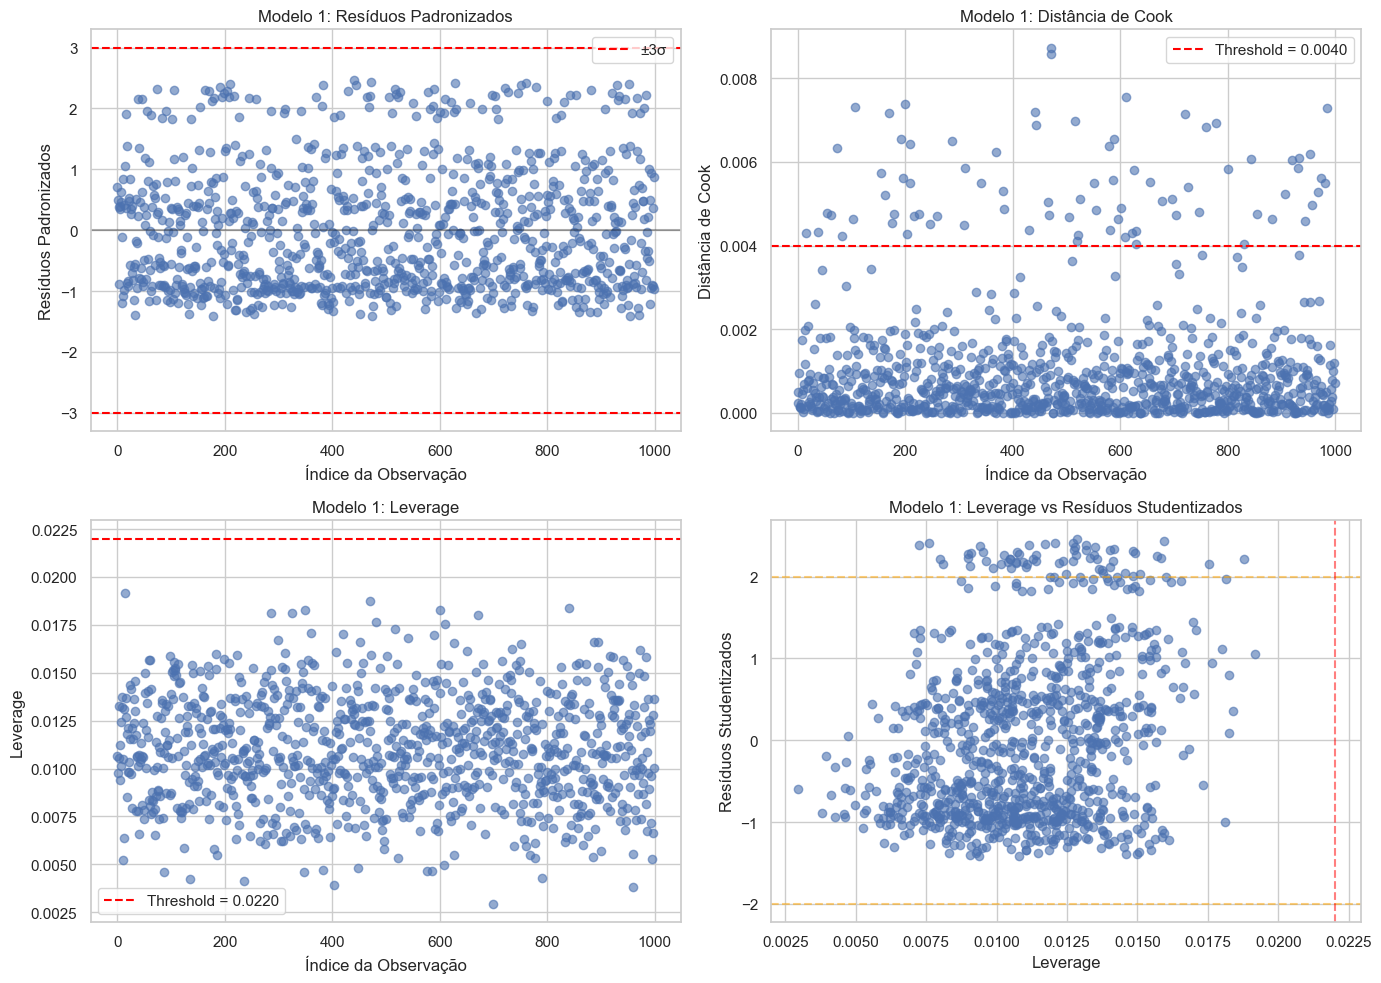

In [23]:
outliers1 = analise_outliers(resultados1, "Modelo 1", X1)


### 6.2. Outliers - Modelo 2



=== Análise de Outliers - Modelo 2 ===
Total de observações: 1000
Número de preditores: 3

Outliers por resíduos padronizados (|resid| > 3): 0
Outliers por Distância de Cook (> 0.0040): 72
Outliers por Leverage (> 0.0080): 6


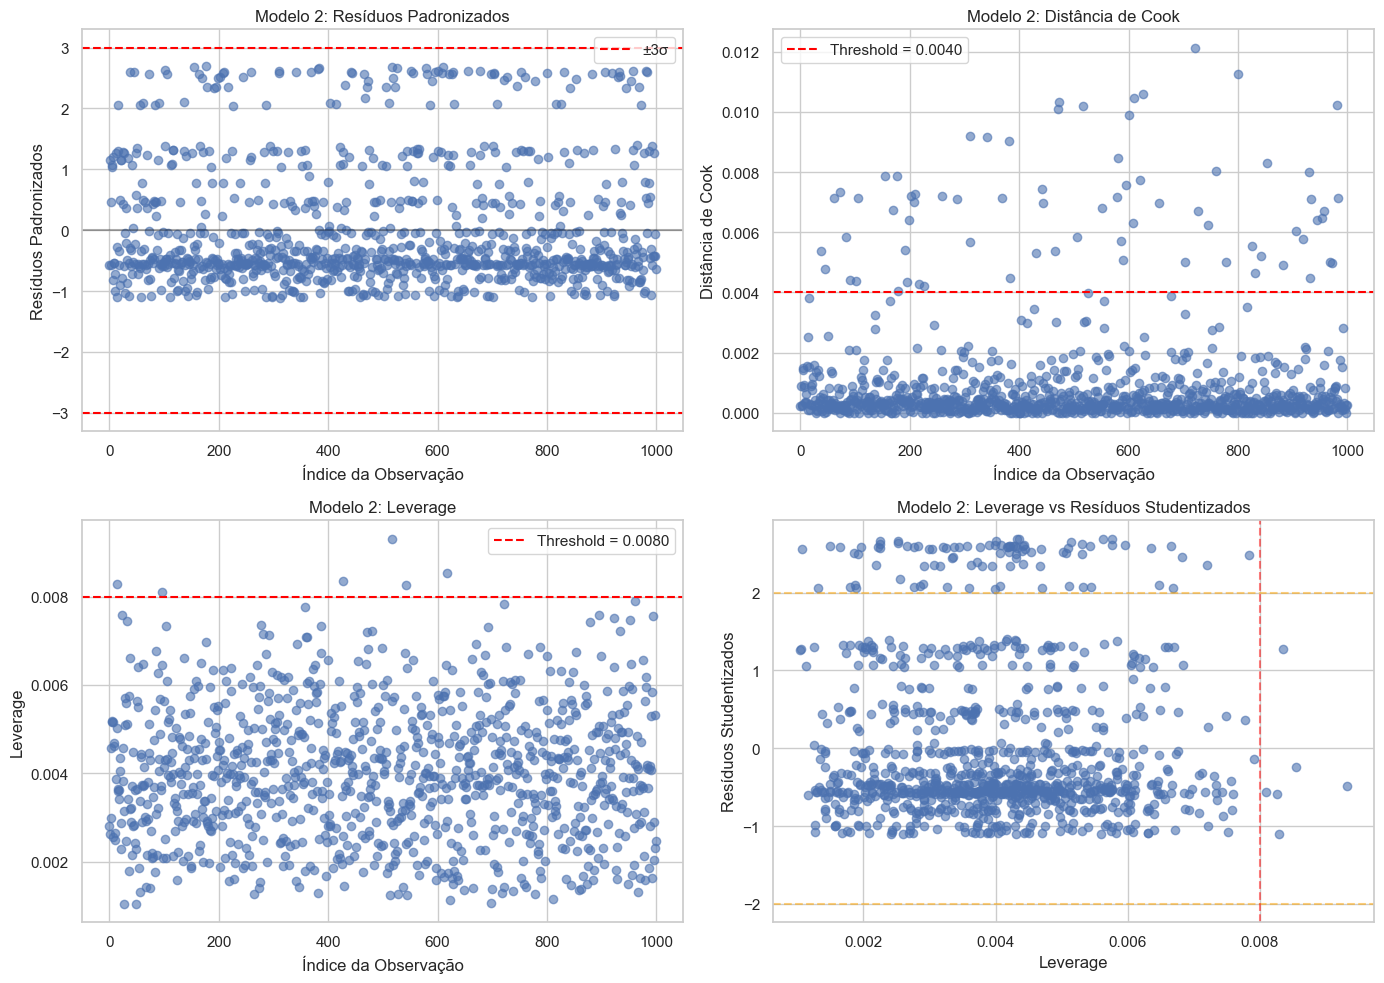

In [24]:
outliers2 = analise_outliers(resultados2, "Modelo 2", X2)


### 6.3. Outliers - Modelo 3



=== Análise de Outliers - Modelo 3 ===
Total de observações: 1000
Número de preditores: 5

Outliers por resíduos padronizados (|resid| > 3): 0
Outliers por Distância de Cook (> 0.0040): 68
Outliers por Leverage (> 0.0120): 2


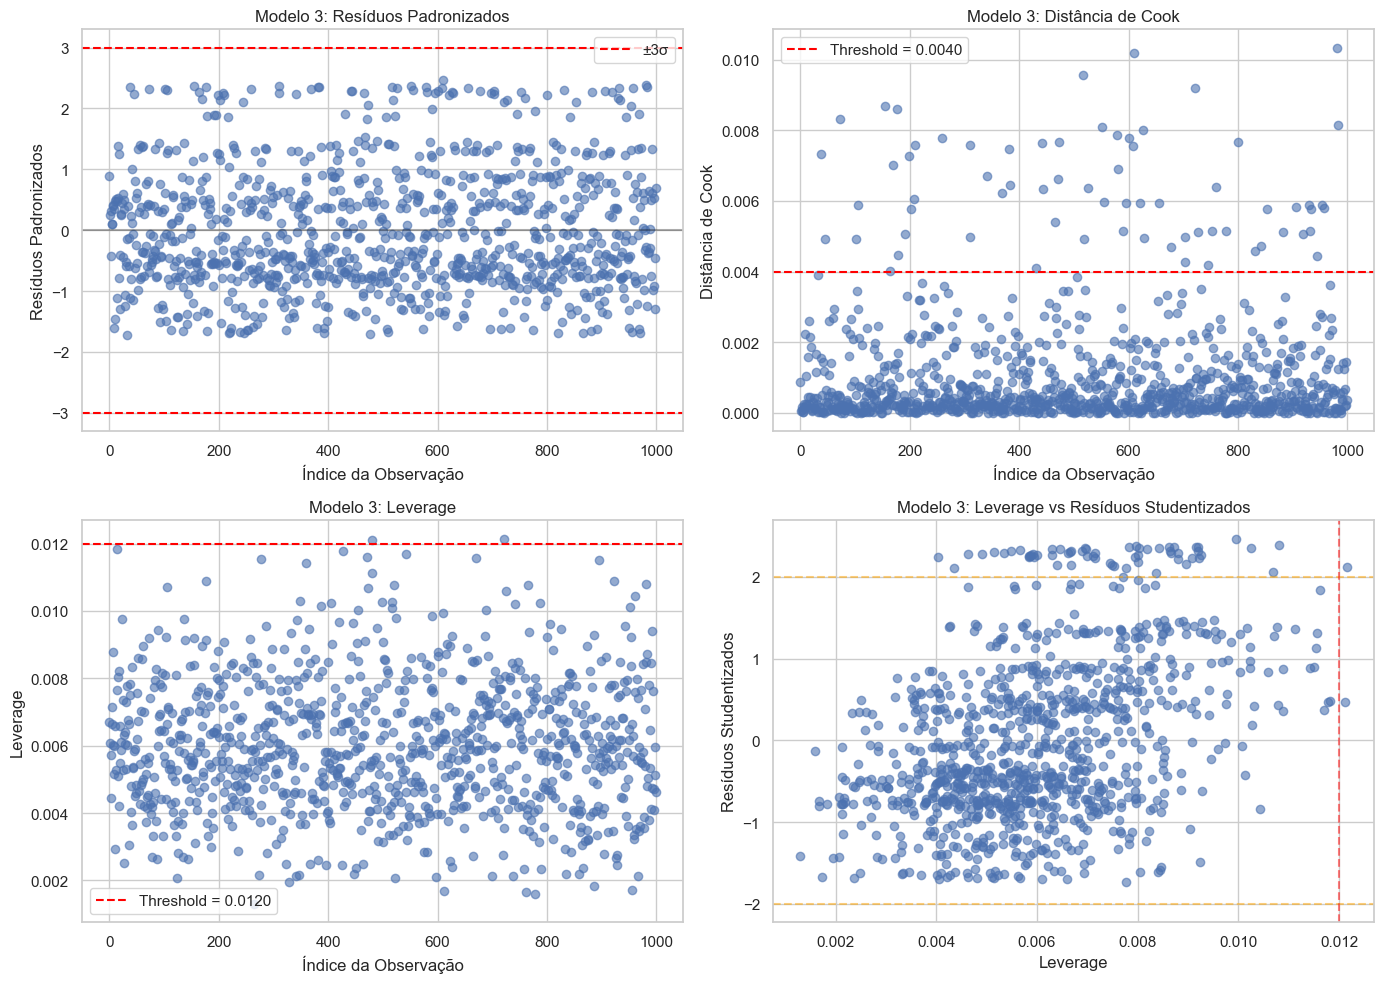

In [25]:
outliers3 = analise_outliers(resultados3, "Modelo 3", X3)


## 7. Comparação de Modelos


In [26]:
# Calcular métricas para cada modelo
def calcular_metricas(resultados, y_true, modelo_nome):
    """Calcula métricas de avaliação do modelo"""
    y_pred = resultados.fittedvalues
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # AIC e BIC
    aic = resultados.aic
    bic = resultados.bic
    
    # R² ajustado
    r2_adj = resultados.rsquared_adj
    
    return {
        'Modelo': modelo_nome,
        'R²': r2,
        'R² Ajustado': r2_adj,
        'RMSE': rmse,
        'MAE': mae,
        'AIC': aic,
        'BIC': bic,
        'Número de Variáveis': len(resultados.params) - 1  # -1 para remover constante
    }

# Calcular métricas para todos os modelos
metricas1 = calcular_metricas(resultados1, y, "Modelo 1 (Todas)")
metricas2 = calcular_metricas(resultados2, y, "Modelo 2 (Top 3)")
metricas3 = calcular_metricas(resultados3, y, "Modelo 3 (Top 5)")

# Criar DataFrame comparativo
df_comparacao = pd.DataFrame([metricas1, metricas2, metricas3])
df_comparacao


,Modelo,R²,R² Ajustado,RMSE,MAE,AIC,BIC,Número de Variáveis
0,Modelo 1 (Todas),0.995250,0.995202,8685.078403,7263.057395,20998.600479,21052.585787,10
1,Modelo 2 (Top 3),0.984279,0.984232,15799.656379,12397.763198,22181.364008,22200.995029,3
2,Modelo 3 (Top 5),0.994745,0.994719,9134.436007,7541.699746,21089.490521,21118.937052,5


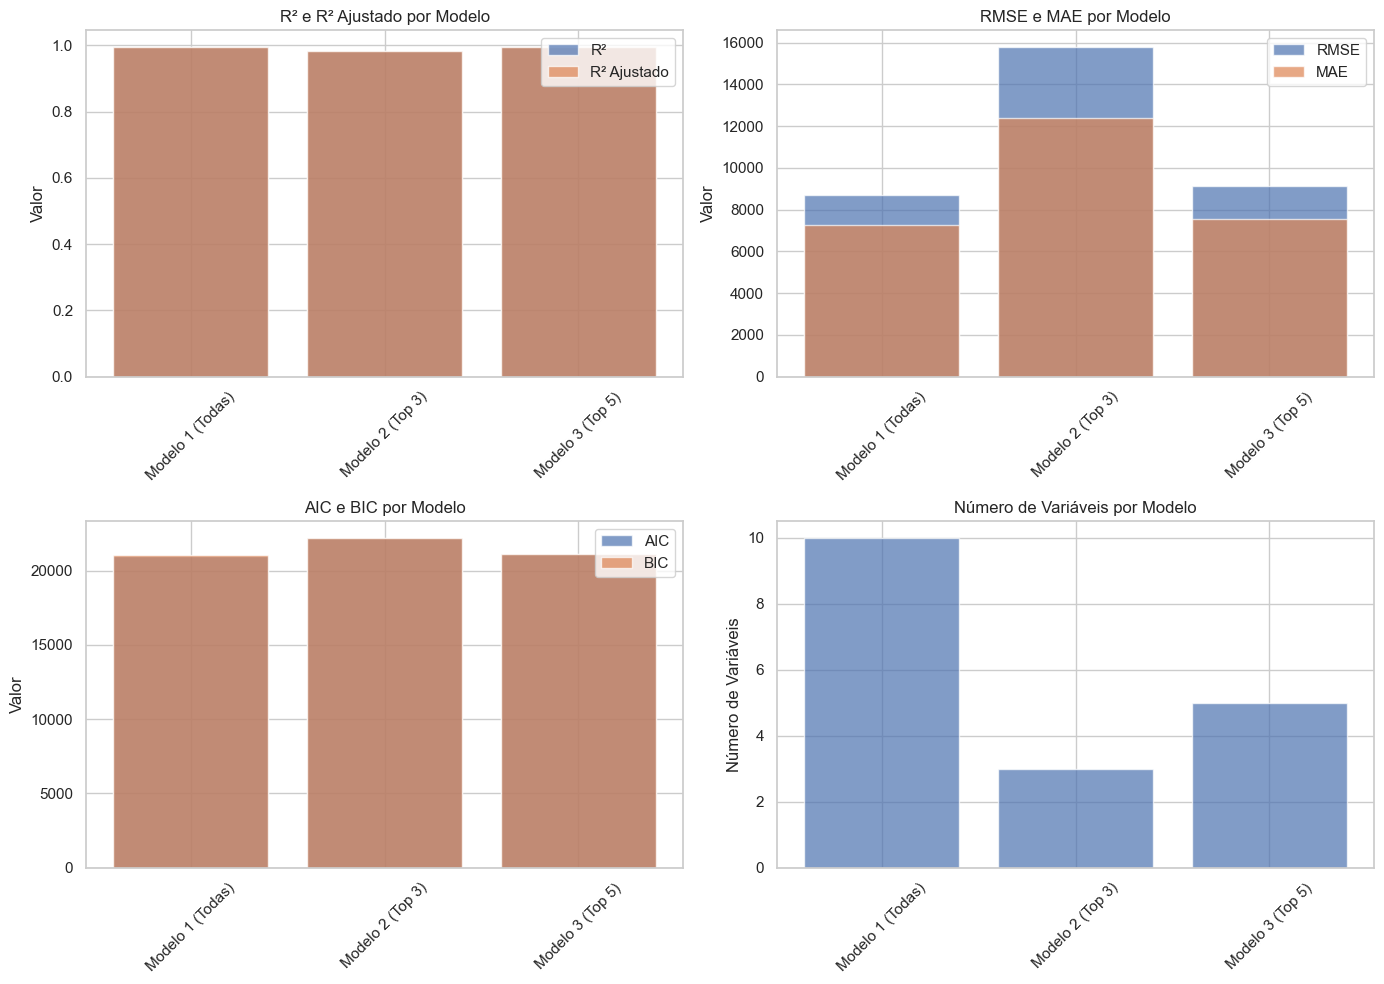

In [33]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² e R² Ajustado
axes[0, 0].bar(df_comparacao['Modelo'], df_comparacao['R²'], alpha=0.7, label='R²')
axes[0, 0].bar(df_comparacao['Modelo'], df_comparacao['R² Ajustado'], alpha=0.7, label='R² Ajustado')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].set_title('R² e R² Ajustado por Modelo')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE e MAE
axes[0, 1].bar(df_comparacao['Modelo'], df_comparacao['RMSE'], alpha=0.7, label='RMSE')
axes[0, 1].bar(df_comparacao['Modelo'], df_comparacao['MAE'], alpha=0.7, label='MAE')
axes[0, 1].set_ylabel('Valor')
axes[0, 1].set_title('RMSE e MAE por Modelo')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# AIC e BIC
axes[1, 0].bar(df_comparacao['Modelo'], df_comparacao['AIC'], alpha=0.7, label='AIC')
axes[1, 0].bar(df_comparacao['Modelo'], df_comparacao['BIC'], alpha=0.7, label='BIC')
axes[1, 0].set_ylabel('Valor')
axes[1, 0].set_title('AIC e BIC por Modelo')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Número de variáveis
axes[1, 1].bar(df_comparacao['Modelo'], df_comparacao['Número de Variáveis'], alpha=0.7)
axes[1, 1].set_ylabel('Número de Variáveis')
axes[1, 1].set_title('Número de Variáveis por Modelo')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


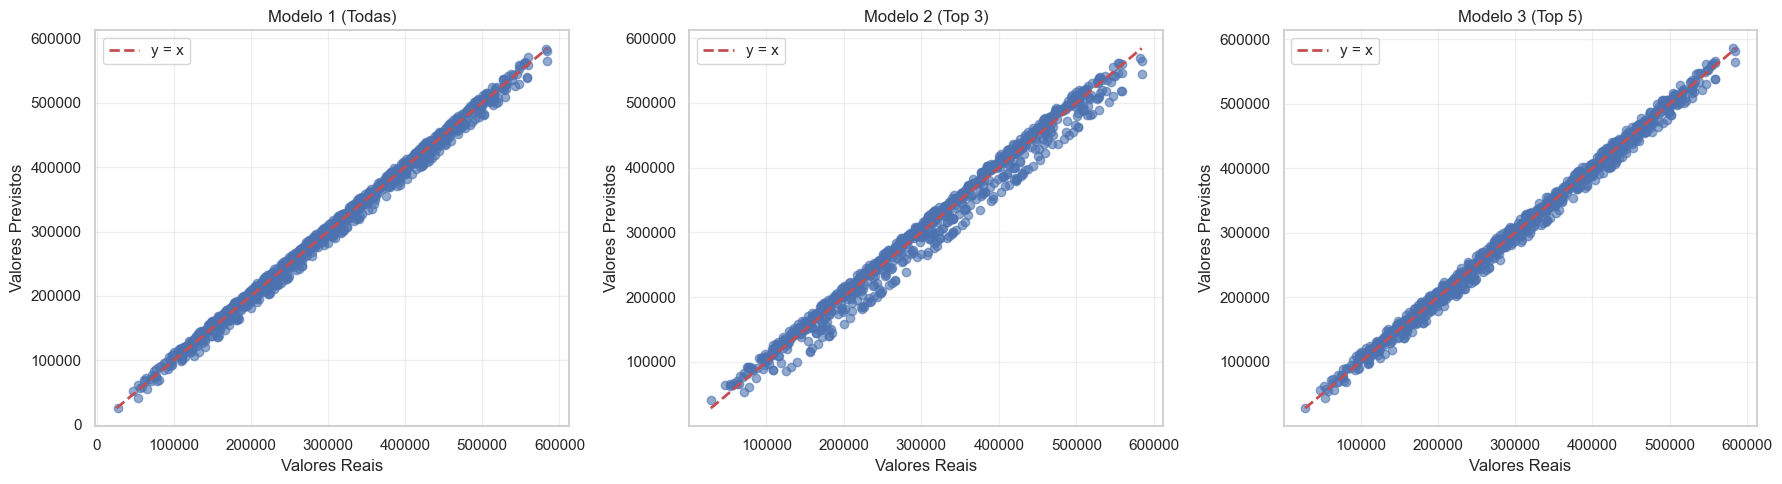

In [34]:
# Comparar valores previstos vs reais para cada modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

modelos = [
    (resultados1, "Modelo 1 (Todas)", axes[0]),
    (resultados2, "Modelo 2 (Top 3)", axes[1]),
    (resultados3, "Modelo 3 (Top 5)", axes[2])
]

for resultados, nome, ax in modelos:
    y_pred = resultados.fittedvalues
    ax.scatter(y, y_pred, alpha=0.6)
    
    # Linha de referência y = x
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y = x')
    
    ax.set_xlabel('Valores Reais')
    ax.set_ylabel('Valores Previstos')
    ax.set_title(nome)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Resumo da Comparação


In [35]:
print("=" * 60)
print("RESUMO COMPARATIVO DOS MODELOS")
print("=" * 60)

print("\n1. MELHOR R²:")
melhor_r2 = df_comparacao.loc[df_comparacao['R²'].idxmax(), 'Modelo']
print(f"   {melhor_r2} (R² = {df_comparacao['R²'].max():.4f})")

print("\n2. MELHOR R² AJUSTADO:")
melhor_r2_adj = df_comparacao.loc[df_comparacao['R² Ajustado'].idxmax(), 'Modelo']
print(f"   {melhor_r2_adj} (R² Ajustado = {df_comparacao['R² Ajustado'].max():.4f})")

print("\n3. MENOR RMSE:")
menor_rmse = df_comparacao.loc[df_comparacao['RMSE'].idxmin(), 'Modelo']
print(f"   {menor_rmse} (RMSE = {df_comparacao['RMSE'].min():.2f})")

print("\n4. MENOR MAE:")
menor_mae = df_comparacao.loc[df_comparacao['MAE'].idxmin(), 'Modelo']
print(f"   {menor_mae} (MAE = {df_comparacao['MAE'].min():.2f})")

print("\n5. MENOR AIC (melhor ajuste penalizado):")
menor_aic = df_comparacao.loc[df_comparacao['AIC'].idxmin(), 'Modelo']
print(f"   {menor_aic} (AIC = {df_comparacao['AIC'].min():.2f})")

print("\n6. MENOR BIC (melhor ajuste penalizado):")
menor_bic = df_comparacao.loc[df_comparacao['BIC'].idxmin(), 'Modelo']
print(f"   {menor_bic} (BIC = {df_comparacao['BIC'].min():.2f})")

print("\n" + "=" * 60)
print("RECOMENDAÇÃO:")
print("=" * 60)

# Determinar melhor modelo baseado em múltiplos critérios
# Considerar R² ajustado, AIC e BIC (penalizam complexidade)
scores = []
for idx, row in df_comparacao.iterrows():
    score = (row['R² Ajustado'] * 0.4) - (row['AIC'] / 100000 * 0.3) - (row['BIC'] / 100000 * 0.3)
    scores.append(score)

melhor_idx = np.argmax(scores)
melhor_modelo = df_comparacao.loc[melhor_idx, 'Modelo']

print(f"\nCom base na análise de R² ajustado, AIC e BIC:")
print(f"O {melhor_modelo} apresenta o melhor equilíbrio entre")
print(f"capacidade preditiva e simplicidade do modelo.")



RESUMO COMPARATIVO DOS MODELOS

1. MELHOR R²:
   Modelo 1 (Todas) (R² = 0.9952)

2. MELHOR R² AJUSTADO:
   Modelo 1 (Todas) (R² Ajustado = 0.9952)

3. MENOR RMSE:
   Modelo 1 (Todas) (RMSE = 8685.08)

4. MENOR MAE:
   Modelo 1 (Todas) (MAE = 7263.06)

5. MENOR AIC (melhor ajuste penalizado):
   Modelo 1 (Todas) (AIC = 20998.60)

6. MENOR BIC (melhor ajuste penalizado):
   Modelo 1 (Todas) (BIC = 21052.59)

RECOMENDAÇÃO:

Com base na análise de R² ajustado, AIC e BIC:
O Modelo 1 (Todas) apresenta o melhor equilíbrio entre
capacidade preditiva e simplicidade do modelo.
